# Predicción de parkinson con muestras de tecleo

# 1- Calculo de nqScore
Este script procesa los datos de tecleo de cada paciente, calculando el nqScore en intervalos de 20 segundos. El nqScore se calcula utilizando todas las métricas disponibles (Key Pressed, Hold Duration, Key Release Time, Key Press Time) junto con el typing speed que se calculara en el intervalo anteriormente mencionado. Los resultados para cada paciente se guardan en un archivo CSV final que contiene el ID de cada paciente y sus nqScores en los diferentes intervalos.

In [490]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay


In [491]:
# Definir el intervalo en segundos
intervalo_segundos = 20
carpeta_csv = 'data_MIT-CSPD'
excel = 'nqScores_pacientes20seg.csv'
modelo = '20.h5'

# Función para calcular el nqScore en un intervalo usando Hold Duration
def calcular_nqScore(intervalo_df):
    hold_times = intervalo_df['Hold Duration (s)'].values

    # Dividir los hold times en ventanas de 20 segundos
    scores = []

    # Calcular el nqScore para el intervalo dado
    if len(hold_times) > 0:
        outliers_count = np.sum((hold_times < np.percentile(hold_times, 25) - 1.5 * (np.percentile(hold_times, 75) - np.percentile(hold_times, 25))) |
                                (hold_times > np.percentile(hold_times, 75) + 1.5 * (np.percentile(hold_times, 75) - np.percentile(hold_times, 25))))

        v_iqr = (np.percentile(hold_times, 75) - np.percentile(hold_times, 25)) / (np.percentile(hold_times, 75) + np.percentile(hold_times, 25))
        histogram, _ = np.histogram(hold_times, bins=4, density=True)

        # Crear el vector de características
        features = [
            outliers_count / len(hold_times),
            v_iqr
        ] + list(histogram)

        # Calcular el nqScore como la media de las hold times
        score = np.mean(hold_times)  # Puedes ajustar esto según lo que necesites
        scores.append(score)

    # Calcular el score promedio
    nqScore = np.mean(scores) if scores else None
    return nqScore

# Crear un diccionario para almacenar los nqScores de cada paciente
nqScores_pacientes = {}

In [492]:


# Procesar cada archivo CSV en la carpeta de pacientes
for archivo in os.listdir(carpeta_csv):
    if archivo.endswith('.csv'):
        # Extraer el ID del paciente desde el nombre del archivo
        id_paciente = archivo.split('.')[0]

        # Leer el archivo de datos del paciente
        ruta_archivo = os.path.join(carpeta_csv, archivo)
        df = pd.read_csv(ruta_archivo)

        # Lista para almacenar los nqScores de cada intervalo del paciente
        nqScores = []

        # Validar la existencia de datos en la columna clave
        if 'Key Release Time (s)' not in df.columns or df['Key Release Time (s)'].isna().all():
            print(f"Advertencia: No se encontraron datos válidos para {id_paciente}.")
            nqScores_pacientes[id_paciente] = [None]
            continue

        # Dividir los datos en intervalos y calcular nqScore por intervalo
        max_time = df['Key Release Time (s)'].max()
        if max_time <= 0 or np.isnan(max_time):
            print(f"Advertencia: Tiempo máximo inválido para {id_paciente}.")
            nqScores_pacientes[id_paciente] = [None]
            continue

        # Verificar que intervalo_segundos sea mayor que 0
        if intervalo_segundos <= 0:
            raise ValueError("El intervalo debe ser un valor positivo mayor que 0.")

        # Usar np.arange para manejar intervalos decimales
        for start_time in np.arange(0, max_time, intervalo_segundos):
            end_time = start_time + intervalo_segundos
            # Filtrar los datos del intervalo actual
            intervalo_df = df[(df['Key Release Time (s)'] >= start_time) & 
                              (df['Key Release Time (s)'] < end_time)]

            # Verifica que el intervalo no esté vacío antes de calcular
            if not intervalo_df.empty:
                # Calcular el nqScore usando el nuevo método
                nqScore = calcular_nqScore(intervalo_df)
                # Guardar el nqScore del intervalo en la lista del paciente
                nqScores.append(nqScore)
            else:
                # Agregar un valor nulo si el intervalo está vacío
                nqScores.append(None)

        # Guardar la lista de nqScores en el diccionario con el ID del paciente como clave
        nqScores_pacientes[id_paciente] = nqScores

# Convertir el diccionario en un DataFrame, con el ID como primera columna
resultados_df = pd.DataFrame.from_dict(nqScores_pacientes, orient='index')
resultados_df.index.name = 'ID'

# Renombrar las columnas como nqScore1, nqScore2, ..., nqScoreN
resultados_df.columns = [f'nqScore{i+1}' for i in range(resultados_df.shape[1])]

# Mostrar los primeros resultados para verificar
print(resultados_df.head())

# Guardar el DataFrame en un archivo CSV
resultados_df.to_csv(excel)

print("Cálculo de nqScores completado y guardado en 'nqScores_pacientes05seg.csv'.")


      nqScore1  nqScore2  nqScore3  nqScore4  nqScore5  nqScore6  nqScore7  \
ID                                                                           
1000  0.141436  0.157953  0.150272  0.155821  0.143659  0.150929  0.139416   
1001  0.125310  0.116817  0.107903  0.115031  0.116398  0.123744  0.112652   
1002  0.074763  0.065527  0.068538  0.070325  0.067903  0.067374  0.071617   
1004  0.097159  0.109232  0.107456  0.115196  0.112371  0.117516  0.116546   
1005  0.103176  0.097032  0.099837  0.090197  0.095195  0.097082  0.096710   

      nqScore8  nqScore9  nqScore10  ...  nqScore20  nqScore21  nqScore22  \
ID                                   ...                                    
1000  0.144613  0.150546   0.149905  ...   0.136705   0.137338   0.136029   
1001  0.107873  0.105300   0.113291  ...   0.108465   0.110062   0.111881   
1002  0.070896  0.066496   0.072498  ...   0.073788   0.070348   0.068457   
1004  0.117373  0.114511   0.113191  ...   0.125619   0.122992   0.1

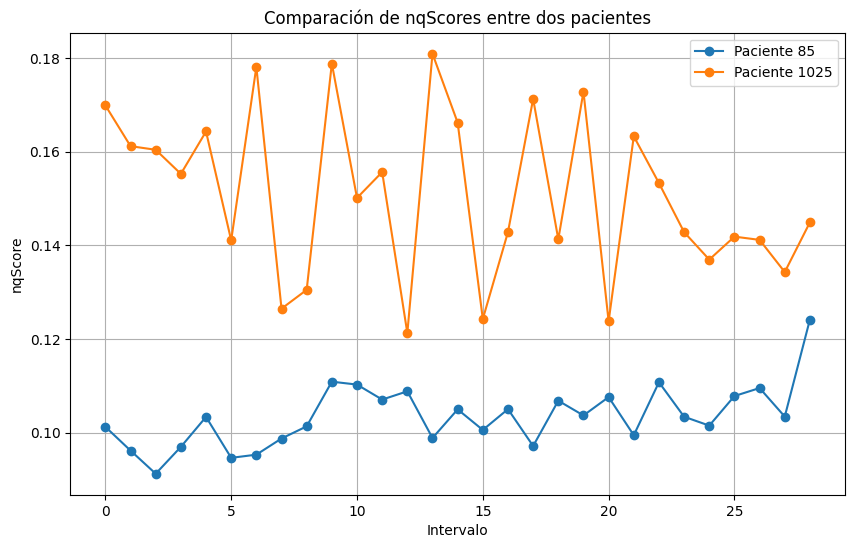

In [493]:
# Cargar el archivo de nqScores de los pacientes
nqScores_df = pd.read_csv(excel, index_col='ID')

# IDs de pacientes para comparar
#falso
paciente1_id = 85
#verdadero
paciente2_id = 1025

# Verificar si los IDs están en el DataFrame
if paciente1_id in nqScores_df.index and paciente2_id in nqScores_df.index:
    # Extraer los nqScores de los pacientes seleccionados
    nqScores_paciente1 = nqScores_df.loc[paciente1_id].dropna().values
    nqScores_paciente2 = nqScores_df.loc[paciente2_id].dropna().values

    # Graficar los nqScores de ambos pacientes
    plt.figure(figsize=(10, 6))
    plt.plot(nqScores_paciente1, label=f'Paciente {paciente1_id}', marker='o')
    plt.plot(nqScores_paciente2, label=f'Paciente {paciente2_id}', marker='o')
    plt.xlabel('Intervalo')
    plt.ylabel('nqScore')
    plt.title('Comparación de nqScores entre dos pacientes')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Uno o ambos IDs no están en el archivo: {paciente1_id}, {paciente2_id}")


# GRU 

In [494]:
# Cargar los archivos
datos_df = pd.read_csv('datos.csv')  # Datos del paciente
nqScores_df = pd.read_csv(excel)  # Scores calculados

# Unir los datos usando una unión externa para ver discrepancias
merged_df = pd.merge(datos_df, nqScores_df, left_on='pID', right_on='ID', how='outer')

# Verifica la unión
print("\nResultados de la unión:")
print(merged_df.head())

# Mostrar cualquier discrepancia en los datos
print("\nValores faltantes en merged_df:")
print(merged_df.isnull().sum())



Resultados de la unión:
   pID     gt  typingSpeed  ID  nqScore1  nqScore2  nqScore3  nqScore4  \
0   11   True   189.372549  11  0.106905  0.108280  0.102963  0.108057   
1   60  False    60.533333  60  0.118848  0.106217  0.112913  0.113135   
2   67   True    54.333333  67  0.195680  0.167500  0.203582  0.195286   
3   68  False    71.800000  68  0.153121  0.156752  0.156717  0.158086   
4   70   True    39.614035  70  0.180138  0.165993  0.177700  0.187867   

   nqScore5  nqScore6  ...  nqScore20  nqScore21  nqScore22  nqScore23  \
0  0.098736  0.097223  ...   0.100352   0.116845   0.112400   0.094945   
1  0.117514  0.127814  ...   0.112174   0.121142   0.136713   0.126173   
2  0.217133  0.216474  ...   0.208810   0.227060   0.224500   0.226882   
3  0.158100  0.158859  ...   0.154596   0.158456   0.154452   0.154979   
4  0.190923  0.185880  ...   0.178933   0.181700   0.209885   0.224400   

   nqScore24  nqScore25  nqScore26  nqScore27  nqScore28  nqScore29  
0   0.099736   

In [495]:
# Rellenar valores faltantes con la media de cada columna
merged_df.fillna(merged_df.mean(), inplace=True)

# Verifica que ya no hay valores faltantes
print("\nValores faltantes después de rellenar:")
print(merged_df.isnull().sum())


Valores faltantes después de rellenar:
pID            0
gt             0
typingSpeed    0
ID             0
nqScore1       0
nqScore2       0
nqScore3       0
nqScore4       0
nqScore5       0
nqScore6       0
nqScore7       0
nqScore8       0
nqScore9       0
nqScore10      0
nqScore11      0
nqScore12      0
nqScore13      0
nqScore14      0
nqScore15      0
nqScore16      0
nqScore17      0
nqScore18      0
nqScore19      0
nqScore20      0
nqScore21      0
nqScore22      0
nqScore23      0
nqScore24      0
nqScore25      0
nqScore26      0
nqScore27      0
nqScore28      0
nqScore29      0
dtype: int64


In [496]:
merged_df['gt'] = merged_df['gt'].astype(int)
# Separar las características (X) y la variable objetivo (y)
X = merged_df.filter(regex='^nqScore')  # Eliminar columnas no necesarias
y = merged_df['gt'].values  # Variable objetivo

# Redimensionar X para que tenga la forma (muestras, tiempo, características)
# Aquí cada paciente es una muestra, el tiempo es la secuencia de nqScores y la característica es solo 1 (el nqScore en cada intervalo)
X = X.values.reshape(X.shape[0], X.shape[1], 1)

#Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifica las dimensiones de los conjuntos
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]}')

Tamaño del conjunto de entrenamiento: 68
Tamaño del conjunto de prueba: 17


In [497]:
# Crear el modelo GRU
model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Activación sigmoide para salida binaria

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)

model.save(modelo)

Epoch 1/20


c:\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.3563 - loss: 0.6943 - val_accuracy: 0.3529 - val_loss: 0.6943
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5251 - loss: 0.6919 - val_accuracy: 0.3529 - val_loss: 0.6982
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5147 - loss: 0.6922 - val_accuracy: 0.3529 - val_loss: 0.6991
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5746 - loss: 0.6888 - val_accuracy: 0.3529 - val_loss: 0.7034
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5451 - loss: 0.6894 - val_accuracy: 0.3529 - val_loss: 0.7061
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6067 - loss: 0.6827 - val_accuracy: 0.3529 - val_loss: 0.7098
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5868 - loss: 0.6822 - val_accuracy: 0.3529 - val_loss: 0.7071
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5755 - loss: 0.6828 - val_accuracy: 0.3529 - val_loss: 0.7044
Epoch 9/20

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8235 - loss: 0.5936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Reporte de clasificación con el modelo cargado: 82.35%
              precision    recall  f1-score   support

       False       0.80      0.67      0.73         6
        True       0.83      0.91      0.87        11

    accuracy                           0.82        17
   macro avg       0.82      0.79      0.80        17
weighted avg       0.82      0.82      0.82        17

Matriz de Confusión:
[[ 4  2]
 [ 1 10]]


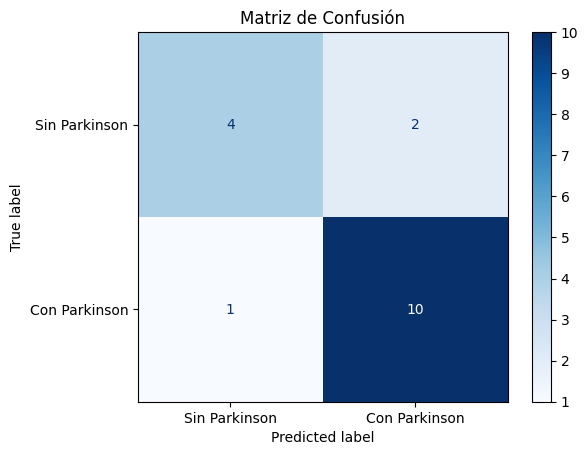

In [498]:
# Cargar el modelo guardado
model = load_model(modelo)

# Evaluar el modelo cargado
loss, accuracy = model.evaluate(X_test, y_test)


# Predecir las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convertir probabilidades a clases

# Generar y mostrar el reporte de clasificación
report = classification_report(y_test, y_pred_classes, target_names=['False', 'True'])
print(f"Reporte de clasificación con el modelo cargado: {accuracy * 100:.2f}%")
print(report)
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(cm)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sin Parkinson', 'Con Parkinson'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

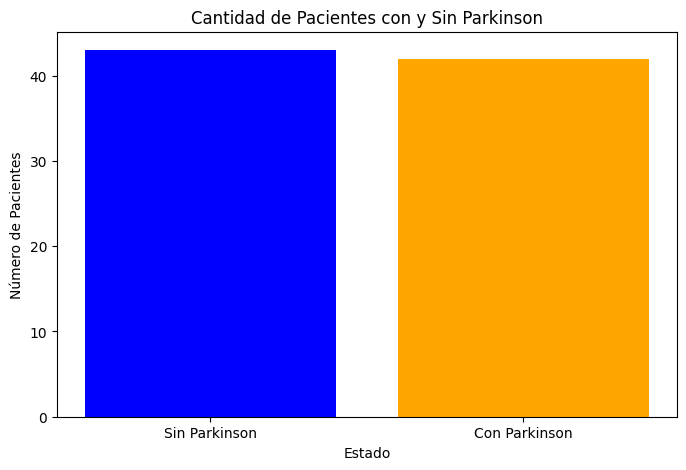

In [499]:
# Cargar los datos
datos_df = pd.read_csv('datos.csv')  

# Contar la cantidad de pacientes con y sin Parkinson
conteo_pacientes = datos_df['gt'].value_counts()

# Preparar los datos para la gráfica
etiquetas = ['Sin Parkinson', 'Con Parkinson']
cantidades = [conteo_pacientes.get(False, 0), conteo_pacientes.get(True, 0)]

# Crear un gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(etiquetas, cantidades, color=['blue', 'orange'])
plt.title('Cantidad de Pacientes con y Sin Parkinson')
plt.xlabel('Estado')
plt.ylabel('Número de Pacientes')
plt.xticks(rotation=0)

plt.show()

# Random forest

In [500]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Separar las características y la variable objetivo
X = merged_df.filter(regex='^nqScore').values  # Convertir en un array numpy
y = merged_df['gt'].values  # Etiquetas objetivo

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [501]:
# Crear el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf_model.predict(X_test)


In [502]:
# Métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Precisión del modelo: 47.06%

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.38      0.83      0.53         6
           1       0.75      0.27      0.40        11

    accuracy                           0.47        17
   macro avg       0.57      0.55      0.46        17
weighted avg       0.62      0.47      0.44        17


Matriz de confusión:
[[5 1]
 [8 3]]


# xtream gradiant boosteam

In [ ]:
#pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [504]:
from sklearn.model_selection import train_test_split

# Separar características y etiquetas
X = merged_df.filter(regex='^nqScore').values  # Características (nqScores)
y = merged_df['gt'].values  # Etiquetas objetivo

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [505]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Crear el modelo XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,       # Número de árboles
    max_depth=6,            # Profundidad máxima de los árboles
    learning_rate=0.1,      # Tasa de aprendizaje
    subsample=0.8,          # Porcentaje de muestras utilizadas por árbol
    colsample_bytree=0.8,   # Porcentaje de características usadas por árbol
    random_state=42
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = xgb_model.predict(X_test)


In [506]:
# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Generar un reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Calcular la matriz de confusión
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Precisión del modelo: 64.71%

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       1.00      0.45      0.62        11

    accuracy                           0.65        17
   macro avg       0.75      0.73      0.65        17
weighted avg       0.82      0.65      0.64        17


Matriz de confusión:
[[6 0]
 [6 5]]


# svm

In [507]:
from sklearn.model_selection import train_test_split

# Separar características (nqScores) y etiquetas (gt)
X = merged_df.filter(regex='^nqScore').values
y = merged_df['gt'].values

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [508]:
from sklearn.preprocessing import StandardScaler

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [509]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Crear el modelo SVM con kernel RBF
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Entrenar el modelo
svm_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = svm_model.predict(X_test)


In [510]:
# Calcular precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo SVM: {accuracy * 100:.2f}%")

# Generar un reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Precisión del modelo SVM: 52.94%

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         6
           1       1.00      0.27      0.43        11

    accuracy                           0.53        17
   macro avg       0.71      0.64      0.51        17
weighted avg       0.80      0.53      0.49        17


Matriz de confusión:
[[6 0]
 [8 3]]
